In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

import matplotlib.pyplot as plt
from read_data import loadData
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [2]:
pd.set_option("display.max_column", None)

In [3]:
df1 = pd.read_csv("./output/data_patch_1.csv")
df2 = pd.read_csv("./output/data_patch_2.csv")
df3 = pd.read_csv("./output/data_patch_3.csv")
df4 = pd.read_csv("./output/data_patch_4.csv")

In [4]:
data_train, testDatasets, expectedRulDatasets = loadData()

In [5]:
drop_col = ['setting_1', 'setting_2', 'setting_3'] 
data_clean = [data.drop(columns = drop_col) for data in data_train]
test_clean = [data.drop(columns = drop_col) for data in testDatasets]

In [6]:
df_all = pd.DataFrame()
for i in range(4):
    df_all =pd.concat([df_all, data_clean[i]])
df_all.reset_index(inplace=True, drop=True)

In [7]:
# df1['engine'] = df_all['engine'][:len(df1)]
# df1['cycle'] = df_all['cycle'][:len(df1)]
# df2['engine'] = df_all['engine'][10000:len(df2)].reset_index(drop=True)
# df2['cycle'] = df_all['cycle'][10000:len(df2)].reset_index(drop=True)
# df3['engine'] = df_all['engine'][50000:len(df3)].reset_index(drop=True)
# df3['cycle'] = df_all['cycle'][50000:len(df3)].reset_index(drop=True)
# df4['engine'] = df_all['engine'][100000:len(df4)].reset_index(drop=True)
# df4['cycle'] = df_all['cycle'][100000:len(df4)].reset_index(drop=True)
# df = pd.concat([df1, df2, df3, df4], axis = 0)


In [8]:
def add_label(df_all, max_perc):
    for engine in list(set(df_all['engine'])):
        max_cycle = df_all[df_all['engine'] == engine]['cycle'].max() 
        condition = (df_all['engine'] == engine) & (df_all['cycle'] > max_cycle*max_perc)
        df_all.loc[condition, 'label'] = 1
    df_all = df_all.fillna(0)
    return df_all

In [9]:
df_all.shape, #df.shape

((160359, 23),)

In [10]:
df_all = add_label(df_all, 0.9)
# df_all_sample = add_label(df, 0.9) # For embedded data

In [11]:
#Without embedding only
correlation_matrix = df_all.drop(columns=['engine', 'cycle']).corr()
high_corr_colm = correlation_matrix[abs(correlation_matrix['label'] )> 0.02].T.columns
df_all_sample = df_all[high_corr_colm.drop("label")]

In [12]:
# df_all_sample.shape, df_all.shape

In [13]:
corr_mat = df_all_sample.corr()

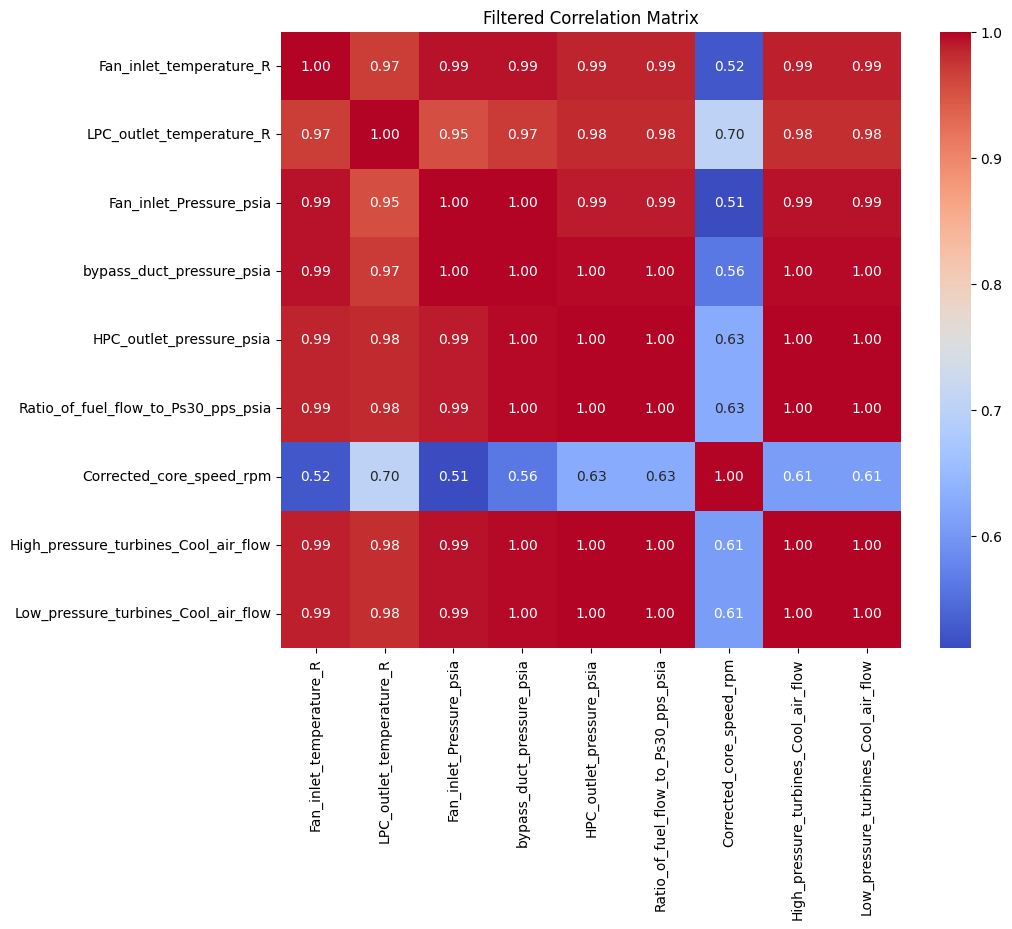

In [14]:
# Plot heatmap for the filtered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Filtered Correlation Matrix')
plt.show()

In [15]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_all_sample) 

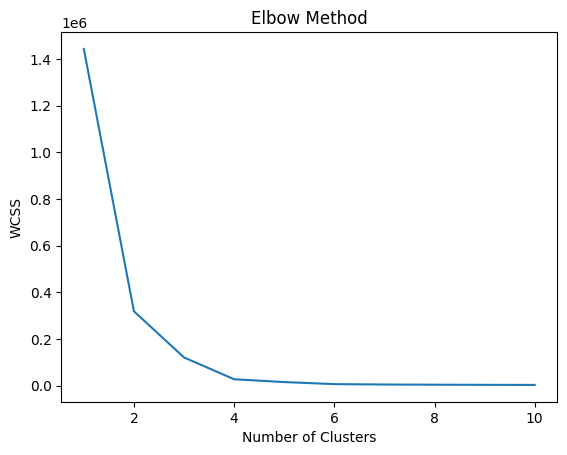

In [19]:
wcss = []  # Within-Cluster Sum of Squares

# Calculate WCSS for k from 1 to max_clusters
max_clusters = 10  # Maximum number of clusters to consider
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is another name for WCSS

# Plot the elbow method graph
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
# df_scaled = np.array(df_patch)

In [16]:
df_all_sample.head(3)

,Fan_inlet_temperature_R,LPC_outlet_temperature_R,Fan_inlet_Pressure_psia,bypass_duct_pressure_psia,HPC_outlet_pressure_psia,Ratio_of_fuel_flow_to_Ps30_pps_psia,Corrected_core_speed_rpm,High_pressure_turbines_Cool_air_flow,Low_pressure_turbines_Cool_air_flow
0,518.67,641.82,14.62,21.61,554.36,521.66,8138.62,39.06,23.4190
1,518.67,642.15,14.62,21.61,553.75,522.28,8131.49,39.00,23.4236
2,518.67,642.35,14.62,21.61,554.26,522.42,8133.23,38.95,23.3442


In [17]:
kmeans = KMeans(n_clusters= 3)
kmeans.fit(df_scaled)

c:\Users\02213R744\anaconda3\envs\patch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [18]:
# labels = kmeans.predict(df_scaled)
labels = kmeans.labels_

In [19]:
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(df_scaled - centroids[labels], axis=1)
distances.max()

2.4461405612588685

In [30]:
1.5/2.4461405612588685

0.6132108774763328

In [31]:
threshold = distances.max()*0.62 #1.7 #4.5
anomalies_indices = np.where(distances > threshold)[0]
anomalies = df_scaled[anomalies_indices]

All the indices were labelled as anomalies by taking cycle as reference

In [32]:
df_all_sample.loc[:, 'actual_label'] = df_all['label']
df_all_sample.reset_index(inplace=True, drop=True)
df_all_sample.loc[:, 'anomaly_label'] = df_all_sample.index.isin(anomalies_indices).astype(int)

embedded_result

In [33]:
from sklearn.metrics import confusion_matrix


In [34]:
cm = confusion_matrix(df_all_sample['actual_label'], df_all_sample['anomaly_label'])

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[136053  16357]
 [  6815   1134]]


In [28]:
report = classification_report(df_all_sample['actual_label'], df_all_sample['anomaly_label'])
print(report)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    156343
         1.0       0.00      0.00      0.00      3887

    accuracy                           0.98    160230
   macro avg       0.49      0.50      0.49    160230
weighted avg       0.95      0.98      0.96    160230



df_all (Raw)

In [35]:
report = classification_report(df_all_sample['actual_label'], df_all_sample['anomaly_label'])
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    152410
         1.0       0.06      0.14      0.09      7949

    accuracy                           0.86    160359
   macro avg       0.51      0.52      0.51    160359
weighted avg       0.91      0.86      0.88    160359



In [34]:
report = classification_report(df_all_sample['actual_label'], df_all_sample['anomaly_label'])
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92    152410
         1.0       0.05      0.10      0.06      7949

    accuracy                           0.86    160359
   macro avg       0.50      0.50      0.49    160359
weighted avg       0.91      0.86      0.88    160359



Test

In [29]:
test_scaled_0 = scaler.transform(test_clean[0][df_engine_1_sample.columns.drop(['actual_label', 'anomaly_label'])])

In [30]:
labels_test = kmeans.predict(test_scaled_0)
distances = np.linalg.norm(test_scaled_0 - centroids[labels_test], axis=1)
distances.max()

2.141809800528277

In [31]:
threshold_test = 1.8
anomalies_indices_test = np.where(distances > threshold_test)[0]
anomalies_test = df_scaled[anomalies_indices_test]

In [32]:
def add_label(df_all):
    for engine in list(set(df_all['engine'])):
        max_cycle = df_all[df_all['engine'] == engine]['cycle'].max() 
        condition = (df_all['engine'] == engine) & (df_all['cycle'] > max_cycle - 25)
        df_all.loc[condition, 'actual_label'] = 1
    df_all = df_all.fillna(0)
    return df_all

In [33]:
test_0_df = test_clean[0]
test_0_df = add_label(test_0_df)

In [34]:
test_0_df['anomaly_label'] = test_0_df.index.isin(anomalies_indices_test).astype(int)

In [35]:
report = classification_report(test_0_df['actual_label'], test_0_df['anomaly_label'])
print(report)

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90     10596
         1.0       0.86      0.01      0.02      2500

    accuracy                           0.81     13096
   macro avg       0.84      0.50      0.46     13096
weighted avg       0.82      0.81      0.73     13096



engine-96

In [ ]:
report = classification_report(df_engine_1_sample['actual_label'], df_engine_1_sample['anomaly_label'])
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      1205
         1.0       0.27      0.32      0.29       100

    accuracy                           0.88      1305
   macro avg       0.61      0.62      0.61      1305
weighted avg       0.89      0.88      0.89      1305



engine-1

In [ ]:
report = classification_report(df_engine_1_sample['actual_label'], df_engine_1_sample['anomaly_label'])
print(report) 

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       821
         1.0       0.66      0.25      0.36       100

    accuracy                           0.90       921
   macro avg       0.79      0.62      0.66       921
weighted avg       0.89      0.90      0.88       921



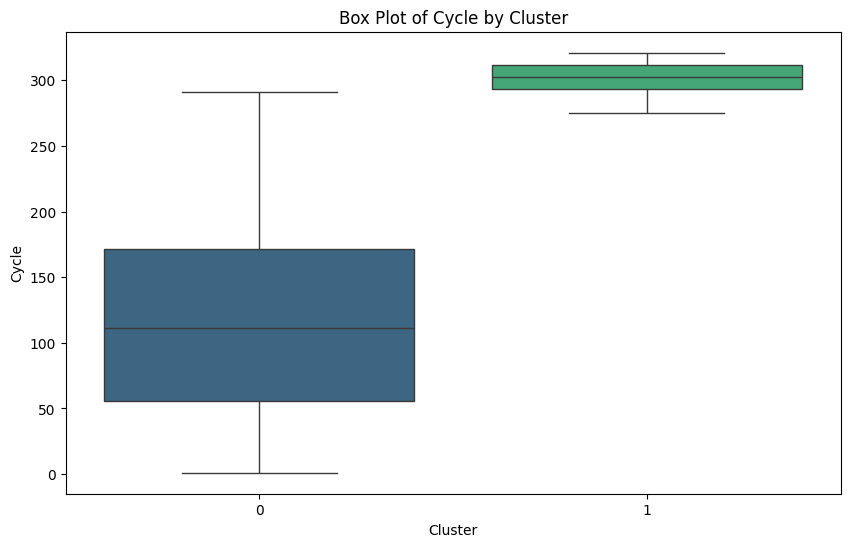

In [ ]:
# Box plot of cycle by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_engine_1_sample, x='anomaly_label', y='cycle',hue= 'anomaly_label', palette='viridis', legend= False)
plt.title('Box Plot of Cycle by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cycle')
plt.show()

All the labels for the anomalies_indics are already 1 based on the cycle

In [ ]:
df_engine_1_sample

,cycle,LPT_outlet_temperature_R,HPC_outlet_Static_pressure_psia,Corrected_core_speed_rpm,label_pred,actual_label
0,1,1400.60,47.47,8138.62,0,0.0
1,2,1403.14,47.49,8131.49,0,0.0
2,3,1404.20,47.27,8133.23,0,0.0
3,4,1401.87,47.13,8133.83,0,0.0
4,5,1406.22,47.28,8133.80,0,0.0
...,...,...,...,...,...,...
916,317,1416.74,47.98,8184.95,0,1.0
917,318,1324.42,46.03,8179.79,0,1.0
918,319,1317.11,46.24,8177.70,0,1.0
919,320,1266.21,45.01,8108.60,1,1.0


In [ ]:
df_engine_1_sample[].index.isin(anomalies_indices)

In [ ]:
for i in range(len(df_engine_1_sample)):
    if i in anomalies_indices:
        df_engine_1_sample.loc[i, 'anomaly_pred'] = 1
    else:
        df_engine_1_sample.loc[i, 'anomaly_pred'] = 0

In [ ]:
df_engine_1_sample['anomaly_pred'].apply(lambda x: 1 if i in anomalies_indices else 0 for i in range(len(df_engine_1_sample)))

,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,...,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
917,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
918,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
919,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
df_engine_1_sample

,cycle,LPT_outlet_temperature_R,HPC_outlet_Static_pressure_psia,Corrected_core_speed_rpm,label_pred,actual_label,anomaly_pred
0,1,1400.60,47.47,8138.62,0,0.0,0.0
1,2,1403.14,47.49,8131.49,0,0.0,0.0
2,3,1404.20,47.27,8133.23,0,0.0,0.0
3,4,1401.87,47.13,8133.83,0,0.0,0.0
4,5,1406.22,47.28,8133.80,0,0.0,0.0
...,...,...,...,...,...,...,...
916,317,1416.74,47.98,8184.95,0,1.0,1.0
917,318,1324.42,46.03,8179.79,0,1.0,1.0
918,319,1317.11,46.24,8177.70,0,1.0,1.0
919,320,1266.21,45.01,8108.60,1,1.0,1.0


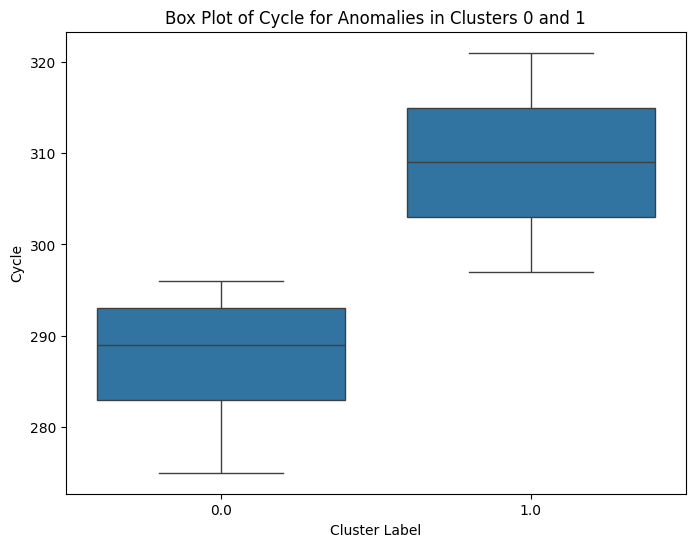

In [ ]:
# Filter anomalies based on cluster labels
# Filter anomalies based on cluster labels
# anomalies_cluster_0 = df_patch[df_patch.index.isin(anomalies_indices) & (df_patch['label'] == 0)]
# anomalies_cluster_1 = df_patch[df_patch.index.isin(anomalies_indices) & (df_patch['label'] == 1)
false_anomalies = df_engine_1_sample[df_engine_1_sample.index.isin(anomalies_indices) & (df_engine_1_sample['actual_label'] == 0)]
true_anomalies = df_engine_1_sample[df_engine_1_sample.index.isin(anomalies_indices) & (df_engine_1_sample['actual_label'] == 1)]

# Combine anomalies from both clusters into a single DataFrame
anomalies_combined = pd.concat([false_anomalies, true_anomalies])

# Box plot of cycle for anomalies in both clusters
plt.figure(figsize=(8, 6))
sns.boxplot(data=anomalies_combined, x='actual_label', y='cycle')
plt.title('Box Plot of Cycle for Anomalies in Clusters 0 and 1')
plt.xlabel('Cluster Label')
plt.ylabel('Cycle')
plt.show()

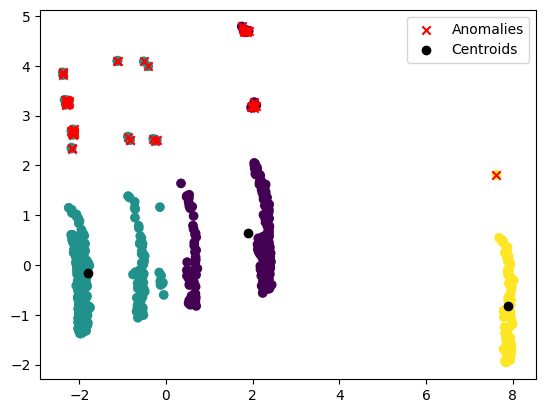

In [ ]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(df_scaled)

# Visualize clusters and anomalies in 2D
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(X_pca[anomalies_indices, 0], X_pca[anomalies_indices, 1], color='red', marker='x', label='Anomalies')
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], color='black', marker='o', label='Centroids')
plt.legend()
plt.show()

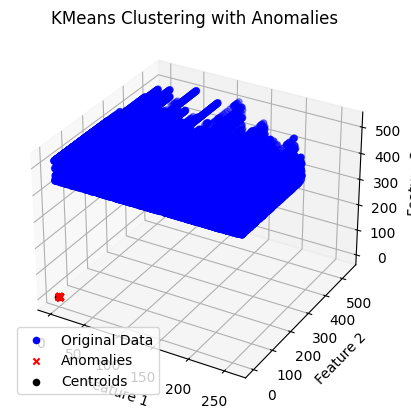

In [ ]:
# Plot the original data points in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_all.iloc[:, 0], df_all.iloc[:, 1], df_all.iloc[:, 2], c='blue', label='Original Data')

# Plot anomalies in 3D
ax.scatter(anomalies[:, 0], anomalies[:, 1], anomalies[:, 2], c='red', marker='x', label='Anomalies')

# Plot cluster centroids in 3D
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', marker='o', label='Centroids')

ax.set_title('KMeans Clustering with Anomalies')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

plt.show()

In [ ]:
df_test = data_clean[0][data_clean[0]['engine'] == 2][['Fan_inlet_temperature_R', 'LPC_outlet_temperature_R','HPC_outlet_temperature_R', 'Low_pressure_turbines_Cool_air_flow']]

In [ ]:
def test_pred(scaler,kmeans,df_test):
    df_scaled_test = scaler.transform(df_test)
    test_labels = kmeans.predict(df_scaled_test)
    return test_labels, df_scaled_test

In [ ]:
test_labels_1, df_scaled_test_1 = test_pred(scaler, kmeans, df_test)

In [ ]:
np.bincount(test_labels_1), np.bincount(test_labels_1[:50])

(array([214,  73], dtype=int64), array([50], dtype=int64))

In [ ]:
df_test2 = data_clean[1][data_clean[1]['engine'] == 2][['Fan_inlet_temperature_R', 'LPC_outlet_temperature_R','HPC_outlet_temperature_R', 'Low_pressure_turbines_Cool_air_flow']]

In [ ]:
test_labels_2, df_scaled_test_2 = test_pred(scaler, kmeans, df_test2)
np.bincount(test_labels_2), np.bincount(test_labels_2[:50])

(array([251,  18], dtype=int64), array([49,  1], dtype=int64))